### If running within a Docker, no action is needed. If not, add the installation path (e.g. 'path_to_fwi3d_directory/local/bin') to the environment variables 'PATH' and 'PYTHONPATH' before running the notebook.

In [1]:
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seppy

sep = seppy.sep()

# Create a directory to store data
!mkdir -p data
datapath = "./data/"

### Generate source time function (Ricker wavelet)

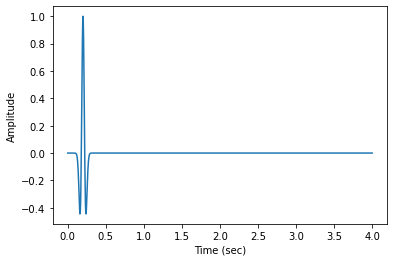

In [2]:
# source time function parameters
nt=1001 # number of time samples
dt=0.004 # sampling rate (sec)
ot=0.0 # origin time
f0=10. # peak frequency (Hz)
shift=50 # shift wavelet (number of samples)

# source wavelet
w=np.zeros(nt)
pi = math.pi
tshift=shift*dt
sig=math.sqrt(2)/(2*f0*pi)
t=np.linspace(0,(nt-1)*dt,nt)
w=(1.0 - ((t-tshift)/sig)**2)*np.exp( -0.5*((t-tshift)/sig)**2)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),w)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

### Generate elastic isotropic models

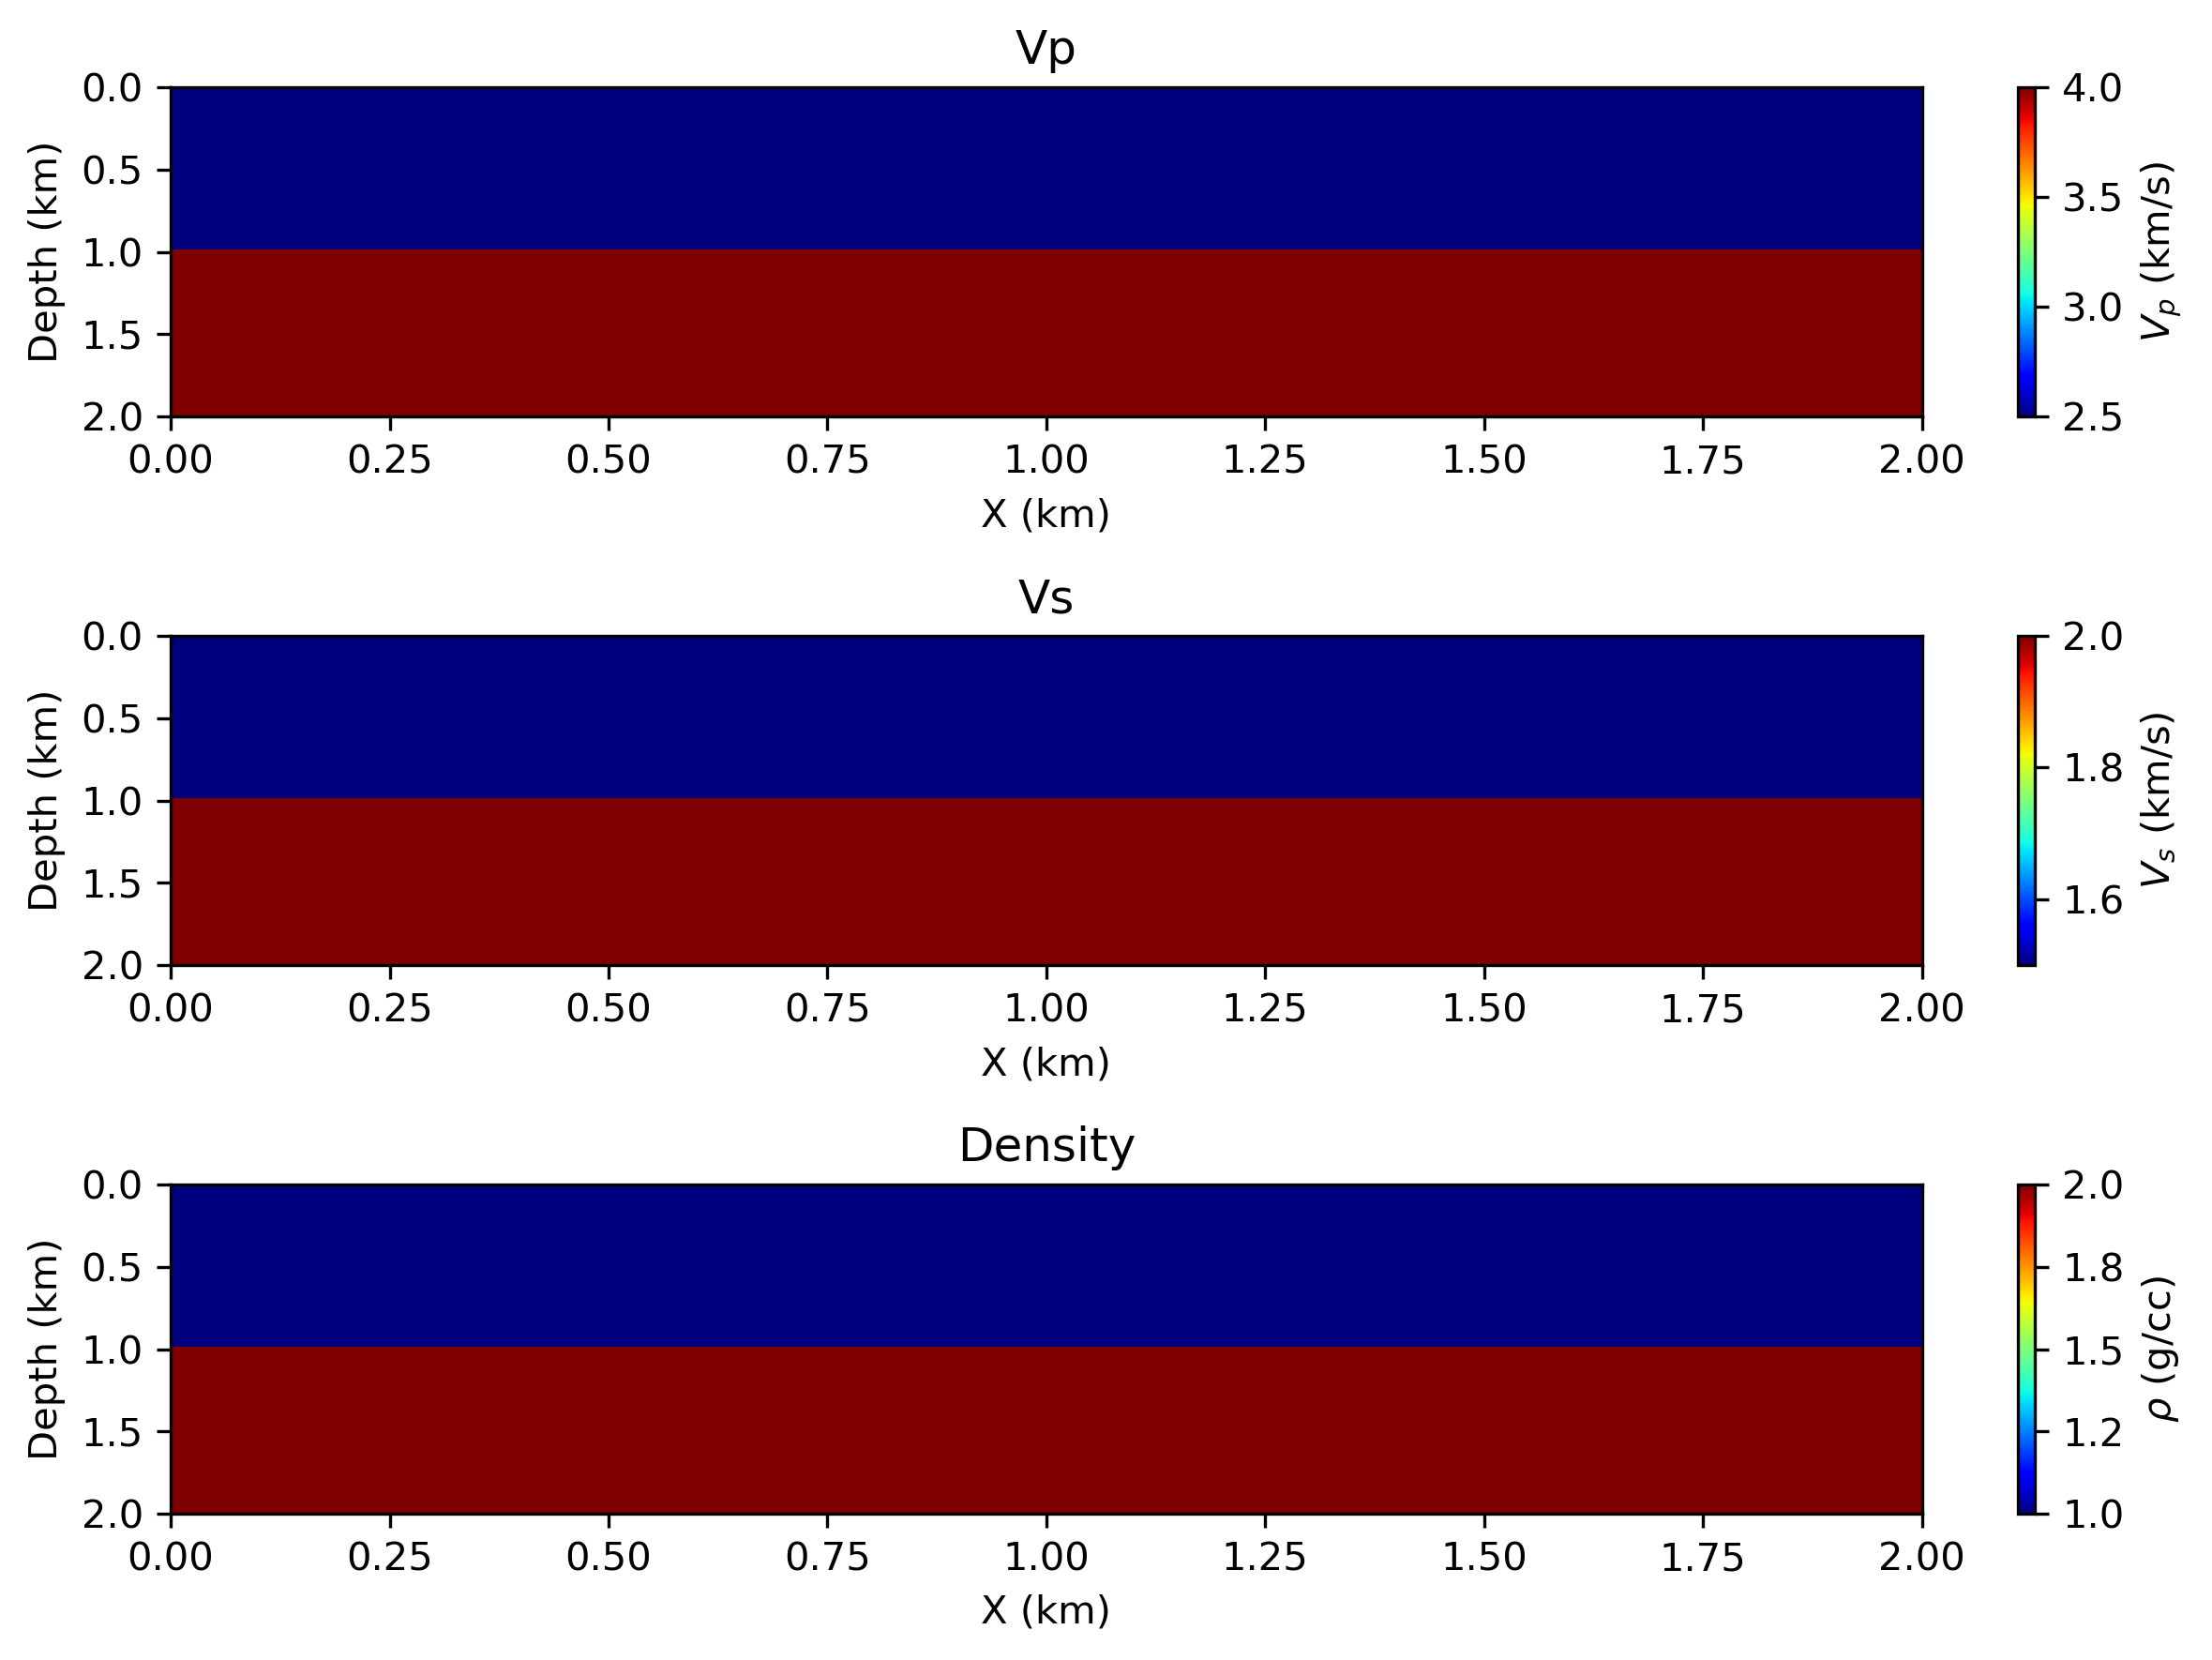

In [3]:
nz=101
nx=101
ny=101
dz=0.02
dx=0.02
dy=0.02
oz=0.0
ox=0.0
oy=0.0
extent = [ox,ox+(nx-1)*dx,oz+(nz-1)*dz,oz]

# two-layers model
model0=np.zeros((3,ny,nx,nz))
model0[0,:,:,:50] = 2.5 # Vp in km/s
model0[0,:,:,50:] = 4.0
model0[1,:,:,:50] = 1.5 # Vs in km/s
model0[1,:,:,50:] = 2.0
model0[2,:,:,:50] = 1.0 # Density in g/cc
model0[2,:,:,50:] = 2.0 # Density in g/cc

model=model0[:,50,:,:]

plt.figure(figsize=(8,6),dpi=300)
plt.subplot(3,1,1)
plt.imshow(np.transpose(model[0,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=2.5,vmax=4.0)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_p$ (km/s)')
plt.title("Vp")

plt.subplot(3,1,2)
plt.imshow(np.transpose(model[1,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=1.5,vmax=2.0)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_s$ (km/s)')
plt.title("Vs")

plt.subplot(3,1,3)
plt.imshow(np.transpose(model[2,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=1.0,vmax=2.0)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\rho$ (g/cc)')
plt.title("Density")

plt.tight_layout()

In [4]:
# save wavelet and models to SEPlib
sep.write_file(datapath+"wavelet.H", w, ds=np.array([dt]), os=np.array([ot]), dpath=datapath)
sep.write_file(datapath+"model0.H", np.transpose(model0), ds=np.array([dz,dx,dy,1]), os=np.array([oz,ox,oy,0]), dpath=datapath)

### Model seismic data

In [5]:
!WE_MODELING_3D.x source=./data/wavelet.H model=./data/model0.H output=./data/data.H parfile=./par/elastic_modeling.p datapath=${PWD}/data/

--------------------------------------------------------------------------
[[60190,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: thanos

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0

Tue Oct 24 00:49:15 2023


 Subsurface model geometry
xmin=0.00000 km, xmax=2.00000 km, dx=0.02000 km, nx=101
ymin=0.00000 km, ymax=2.00000 km, dy=0.02000 km, ny=101
zmin=0.00000 km, zmax=2.00000 km, dz=0.02000 km, nz=101

 Boundary conditions
Top boundary condition = free surface	 taper size = 0
Bottom boundary condition = locally absorbing	 taper size = 25
Left boundary condition = locally absorbing	 taper size = 25
Right boundary c

In [9]:
# load, and plot
ns=2 # number of shots
ncomp=3 # number of components
axes_data, data = sep.read_file(datapath+"data.H")
data = data.reshape([axes_data.n[0],int(axes_data.n[1]/(ns*ncomp)),ncomp,ns],order='F').T

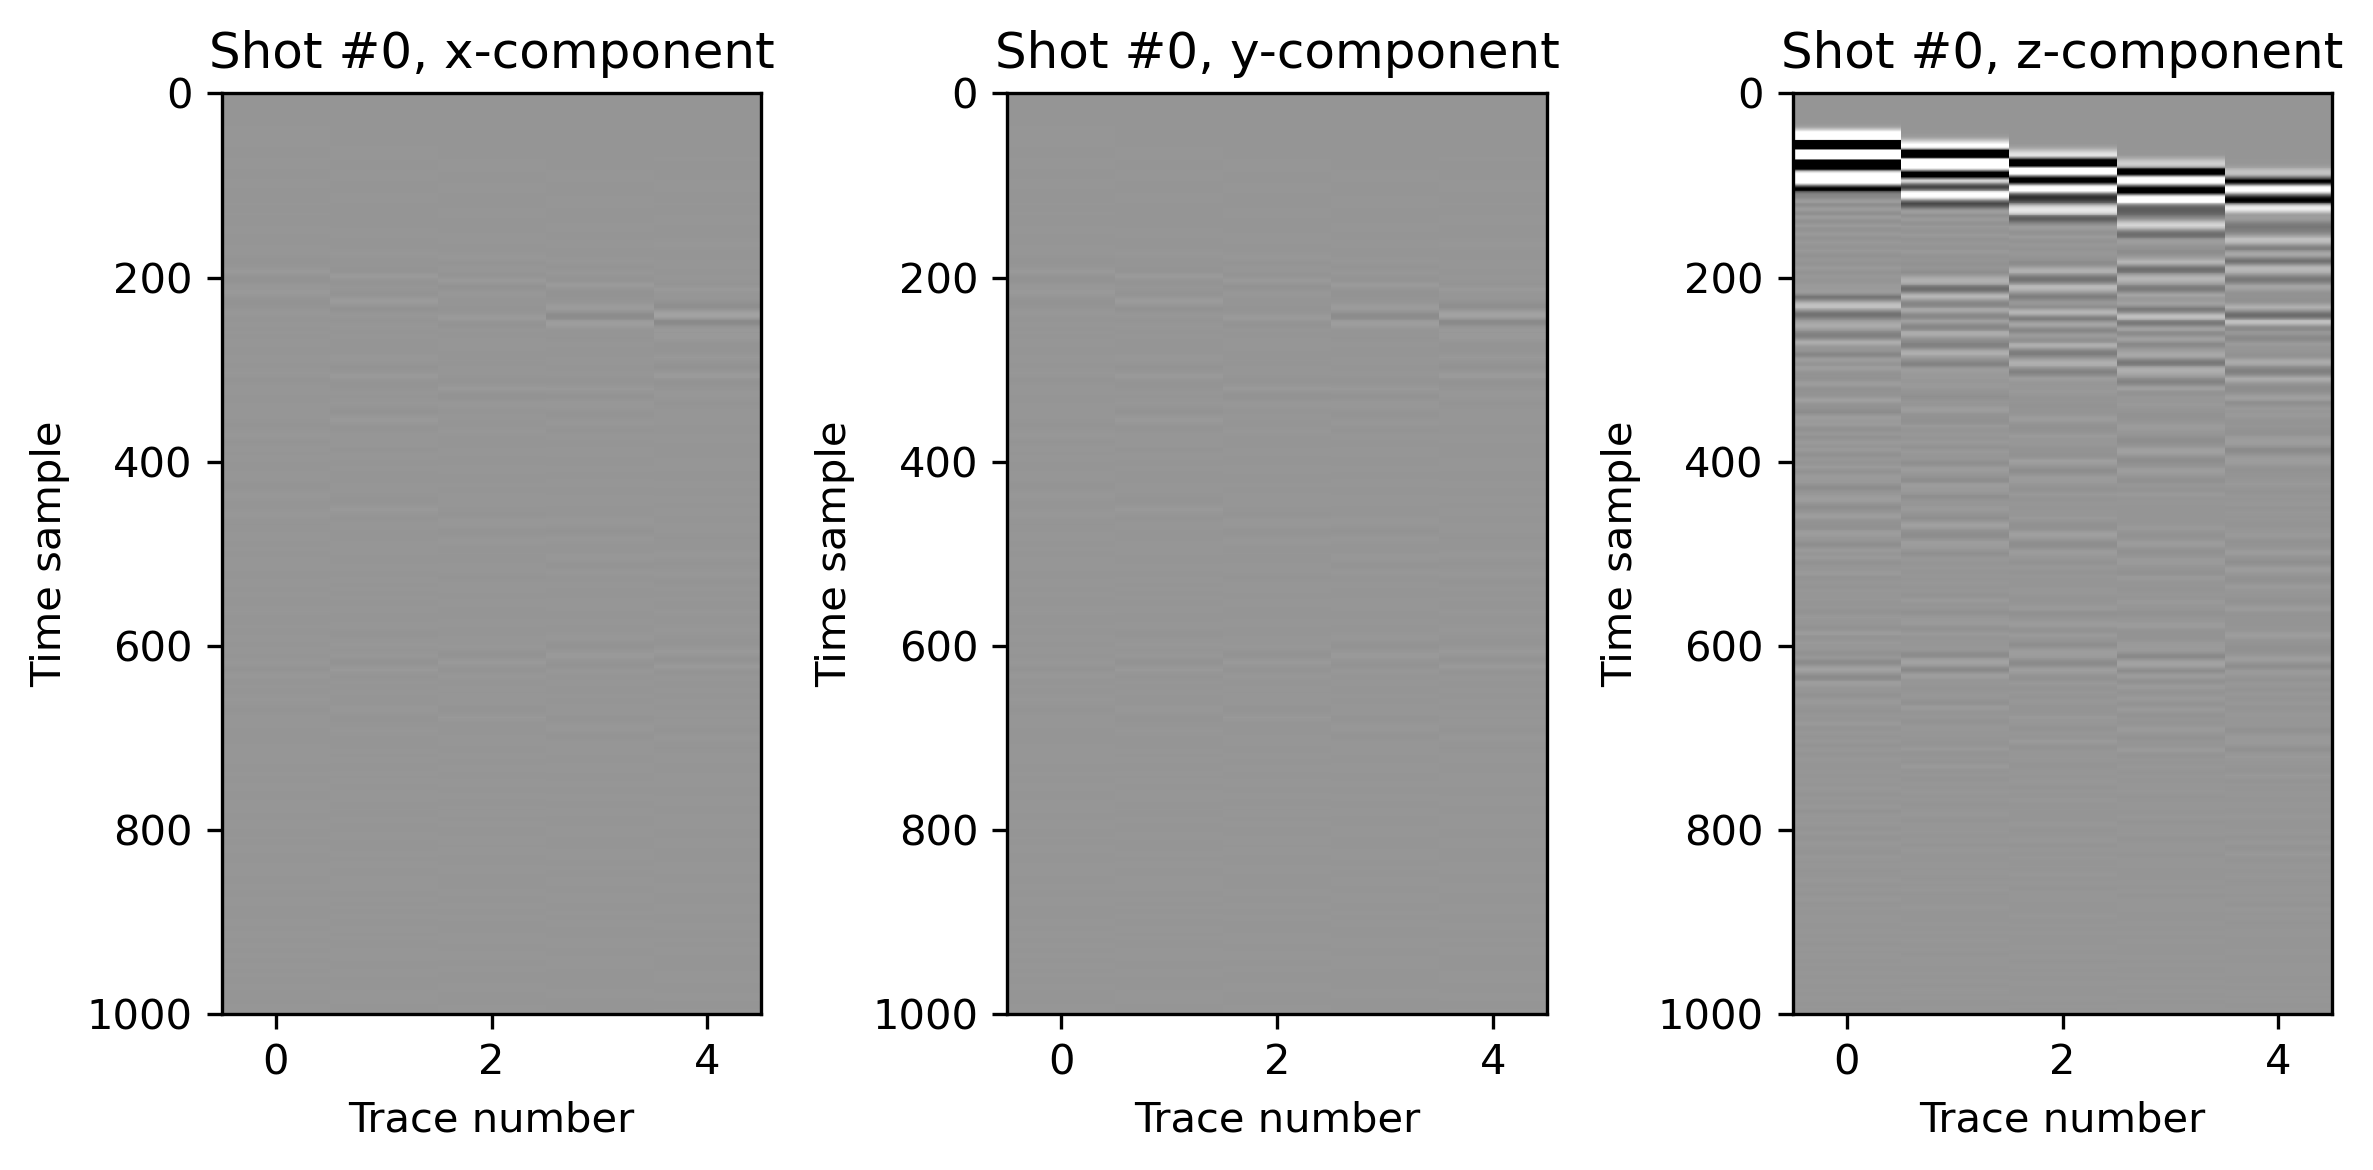

In [11]:
s=0
d=data[s,:,:,:]
vmax=np.amax(d)
p=0.1

plt.figure(figsize=(8,4),dpi=300)
plt.subplot(1,3,1)
plt.imshow(np.transpose(d[0]),interpolation='none',aspect="auto",cmap='Greys',vmax=p*vmax,vmin=-p*vmax)
plt.xlabel('Trace number')
plt.ylabel('Time sample')
plt.title("Shot #%s, x-component" %s)

plt.subplot(1,3,2)
plt.imshow(np.transpose(d[1]),interpolation='none',aspect="auto",cmap='Greys',vmax=p*vmax,vmin=-p*vmax)
plt.xlabel('Trace number')
plt.ylabel('Time sample')
plt.title("Shot #%s, y-component" %s)

plt.subplot(1,3,3)
plt.imshow(np.transpose(d[2]),interpolation='none',aspect="auto",cmap='Greys',vmax=p*vmax,vmin=-p*vmax)
plt.xlabel('Trace number')
plt.ylabel('Time sample')
plt.title("Shot #%s, z-component" %s)

plt.tight_layout()
plt.show()

Clean up the data directory

In [1]:
!rm -rf data